# Word Embeddings - Ejercicio práctico de tratamiento de etiquetas

## 0. Configuración del entorno

Para abordar el ejercicio se procede a verificar e instalar las bibliotecas de Python necesarias para el desarrollo de este análisis. Adicionalmente, se mostrará la versión de Python en uso, así como las versiones de las bibliotecas instaladas.

### Bibliotecas requeridas:

* [NumPy](https://numpy.org/): proporciona soporte para arrays y matrices, junto con una amplia colección de funciones matemáticas de alto nivel para operar sobre estos arrays.
* [Pandas](https://pandas.pydata.org/): ofrece estructuras de datos flexibles y expresivas diseñadas para facilitar el trabajo con datos estructurados (tabulares, multidimensionales, potencialmente heterogéneos) y series temporales.
* [Matplotlib](https://matplotlib.org/): permite la generación de una gran variedad de gráficos, desde simples diagramas de líneas y dispersión hasta visualizaciones más complejas en 2D y 3D.
* [Scikit-learn](https://scikit-learn.org/stable/): implementa una amplia gama de algoritmos de aprendizaje automático para tareas como clasificación, regresión, *clustering* y reducción de dimensionalidad.
* [Tabulate](https://pypi.org/project/tabulate/): facilita la presentación de datos en tablas de formato legible, con soporte para diversos estilos y opciones de personalización.
* [Gensim](https://radimrehurek.com/gensim/): diseñada para el modelado de temas, el procesamiento de documentos y la recuperación de información mediante el uso de algoritmos escalables.
* [Seaborn](https://seaborn.pydata.org/): proporciona una interfaz de alto nivel basada en Matplotlib para la visualización de datos estadísticos. Facilita la creación de gráficos atractivos y complejos con una sintaxis sencilla.
* [Requests](https://requests.readthedocs.io/en/latest/): ofrece una interfaz simple y amigable para realizar solicitudes HTTP, permitiendo la interacción con APIs y servicios web de manera sencilla y eficiente, con soporte para peticiones GET, POST, autenticación y manejo de errores.
* [Graphviz](https://graphviz.org/): facilita la creación de diagramas y gráficos a partir de descripciones textuales, utilizando el formato DOT. Es ideal para representar estructuras de datos como árboles, redes y grafos dirigidos o no dirigidos.

En el bloque de código mostrado a continuación se instalan las bibliotecas mencionadas.

In [1]:
#Se cargan librerías de base de Python para, entre otras funciones, poder gestionar la instalación y carga dinámica de librerías
import importlib
import subprocess
import sys
import time
import zipfile
import re
import tabulate

def instalar_paquetes(paquetes):
    """
    Instala paquetes Python si no están ya instalados y muestra sus versiones.

    Args:
    paquetes (list): Una lista de nombres de paquetes como cadenas.

    Descripción:
    Esta función recibe una lista de nombres de paquetes y realiza las siguientes acciones:
    1. Verifica si cada paquete ya está instalado.
    2. Si el paquete no está instalado, lo instala utilizando pip.
    3. Muestra la versión del paquete, ya sea que estuviera instalado previamente o se haya instalado ahora.
    4. Si ocurre un error durante la instalación, imprime un mensaje de error.
    5. Maneja casos especiales como 'scikit-learn' y 'GitPython'.

    Adicionalmente, imprime la versión de Python en uso.
    """
    print(f"Python: versión {sys.version.split()[0]}")
    for paquete in paquetes:
        nombre_importacion = paquete
        nombre_instalacion = paquete

        if paquete == 'scikit-learn':
            nombre_importacion = 'sklearn'
        elif paquete == 'GitPython':
            nombre_importacion = 'git'

        try:
            # Intenta importar el paquete para verificar si ya está instalado
            modulo = importlib.import_module(nombre_importacion)
            version = getattr(modulo, '__version__', 'Versión desconocida')
            print(f"{paquete} ya está instalado. Versión: {version}")
        except ImportError:
            # Si el paquete no está instalado, lo instala
            try:
                print(f"Instalando {paquete}...")
                subprocess.check_call([sys.executable, "-m", "pip", "install", nombre_instalacion])
                # Importa el paquete recién instalado para obtener su versión
                modulo = importlib.import_module(nombre_importacion)
                version = getattr(modulo, '__version__', 'Versión desconocida')
                print(f"{paquete} ha sido instalado correctamente. Versión: {version}")
            except subprocess.CalledProcessError:
                print(f"Error al instalar {paquete}.")

# Lista de paquetes a instalar
paquetes_a_instalar = ['numpy', 'pandas', 'matplotlib', 'scikit-learn', 'tabulate', 'gensim', 'requests', 'seaborn', 'graphviz', 'GitPython']
instalar_paquetes(paquetes_a_instalar)


Python: versión 3.10.12
numpy ya está instalado. Versión: 1.26.4
pandas ya está instalado. Versión: 2.2.2
matplotlib ya está instalado. Versión: 3.8.0
scikit-learn ya está instalado. Versión: 1.5.2
tabulate ya está instalado. Versión: 0.9.0
gensim ya está instalado. Versión: 4.3.3
requests ya está instalado. Versión: 2.32.3
seaborn ya está instalado. Versión: 0.13.2
graphviz ya está instalado. Versión: 0.20.3
GitPython ya está instalado. Versión: 3.1.43


## 1. Embeddings - Concepto y Evaluación

### 1.1 Embeddings: Representaciones significativas del lenguaje

Los *embeddings* son vectores numéricos que representan palabras o frases en un espacio de alta dimensionalidad. La característica clave de los *embeddings* es que capturan relaciones semánticas y sintácticas entre las palabras. Palabras con significados similares o que aparecen en contextos similares tendrán *embeddings* cercanos en este espacio.

Gensim es una biblioteca de Python de código abierto diseñada para el modelado de temas, el procesamiento de documentos y la recuperación de información mediante el uso de algoritmos escalables. Proporciona herramientas eficientes para trabajar con grandes corpus de texto y ofrece una interfaz sencilla para cargar y utilizar modelos de *embeddings* pre-entrenados. Conceptualmente, entrenar modelos de *embeddings* puede ser visto como obtener un gran corpus de texto y capturar en una representación vectorial de cada palabra el sentido semántico de dichas palabras.

### 1.2 Modelos GloVe - GloVe-Twitter-50

En el ejercicio se utilizan *embeddings* generados por un modelo entrenado con el algoritmo de aprendizaje automático no supervisado GloVe [*Global Vectors for Word Representation*](https://nlp.stanford.edu/projects/glove/). Este es un algoritmo de aprendizaje automático que trabaja de forma no supervisada, lo que significa que aprende por sí mismo analizando grandes cantidades de texto. Su funcionamiento se basa en estudiar cuántas veces y cuán cerca aparecen las palabras entre sí en los textos. Como resultado, cada palabra se convierte en un vector (una serie de números) de tal manera que palabras con significados similares o que se usan en contextos parecidos tendrán valores numéricos cercanos entre sí.

En concreto, se usará en el ejercicio `glove-twitter-50`,  un conjunto de *embeddings* de palabras entrenados en un corpus multiidioma de dos billones de tweets. Cada palabra está representada por un vector de 50 dimensiones.

En el siguiente bloque de código se importan estos *embeddings* y se proporciona información básica sobre su uso.

In [4]:
#Se cargan los embeddings de glove-twitter-50 junto con el resto de librerias necesarias para el análisis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import downloader as embeddings
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tabulate import tabulate

try:
        inicio = time.time()
        print("Cargando los embeddings..")
        w2v = embeddings.load("glove-twitter-50")
        print("Se han cargado los embeddings")
        tiempo_transcurrido = time.time() - inicio

        print(f"Tiempo de carga: {tiempo_transcurrido:.2f} segundos")

        #Exploración de los embeddings importados
        vocabulario = len(w2v)  # Tamaño del vocabulario
        palabra_ejemplo = 'manzana'  # Palabra de ejemplo

        try:
            vector_ejemplo = w2v[palabra_ejemplo]  # Vector asociado a la palabra
            longitud_vector = len(vector_ejemplo)  # Longitud del vector

            info = f"""
            # Información Básica de los Embeddings

            - **Tamaño del vocabulario:** {vocabulario}
            - **Ejemplo de palabra:** '{palabra_ejemplo}'
            - **Vector de la palabra '{palabra_ejemplo}':** {vector_ejemplo}
            - **Longitud del vector:** {longitud_vector}
            """

            print(info)

        except KeyError:
            print(f"La palabra '{palabra_ejemplo}' no existe en el vocabulario de embeddings.")
except Exception as e:
        print(f"Error al cargar los embeddings: {str(e)}")

Cargando los embeddings..
Se han cargado los embeddings
Tiempo de carga: 59.48 segundos

            # Información Básica de los Embeddings

            - **Tamaño del vocabulario:** 1193514
            - **Ejemplo de palabra:** 'manzana'
            - **Vector de la palabra 'manzana':** [-1.1427e+00 -4.2742e-01 -4.1550e-01  1.4874e-01  3.9952e-01  5.9030e-02
 -1.2957e+00 -9.9847e-02  4.4939e-01 -8.6626e-01 -5.7454e-02 -1.1907e+00
 -3.5051e-01  5.1866e-01  5.9488e-01  1.2582e-01  1.5161e+00  3.6131e-01
  9.5733e-01  1.2364e-01  3.7305e-01 -1.8179e-01  4.3155e-01  2.5387e-01
  1.0300e+00 -1.5981e+00 -5.9478e-01 -8.9183e-01  1.1409e+00 -4.7717e-01
  1.9447e-01  5.4418e-01  4.9993e-01 -2.3788e-01 -8.5996e-01  1.3421e-01
  3.4272e-04  3.7579e-01 -3.6425e-01  1.5911e+00 -6.0125e-01 -1.3403e+00
 -1.0364e+00 -2.8375e-01  7.2215e-01 -4.5471e-01 -3.5960e-01  9.5688e-01
 -8.0310e-02 -2.0519e-01]
            - **Longitud del vector:** 50
            


En aproximadamente 3 minutos se obtiene:
- **Tamaño del vocabulario:** 1.193.514  
  Esto significa que el modelo de *embeddings* tiene representaciones para 1.193.514 palabras diferentes. Cada palabra tiene asociado un vector de 50 dimensiones.
- **Ejemplo de palabra `'manzana'`:**
  como ejemplo, se ha seleccionado la palabra "manzana" para mostrar cómo el modelo representa esta palabra en un espacio vectorial.
- **Vector de la palabra `'manzana'`:**
  ```python
  [-1.1427e+00, -4.2742e-01, -4.1550e-01,  1.4874e-01,  3.9952e-01,  5.9030e-02,
   -1.2957e+00, -9.9847e-02,  4.4939e-01, -8.6626e-01, -5.7454e-02, -1.1907e+00,
   -3.5051e-01,  5.1866e-01,  5.9488e-01,  1.2582e-01,  1.5161e+00,  3.6131e-01,
    9.5733e-01,  1.2364e-01,  3.7305e-01, -1.8179e-01,  4.3155e-01,  2.5387e-01,
    1.0300e+00, -1.5981e+00, -5.9478e-01, -8.9183e-01,  1.1409e+00, -4.7717e-01,
    1.9447e-01,  5.4418e-01,  4.9993e-01, -2.3788e-01, -8.5996e-01,  1.3421e-01,
    3.4272e-04,  3.7579e-01, -3.6425e-01,  1.5911e+00, -6.0125e-01, -1.3403e+00,
   -1.0364e+00, -2.8375e-01,  7.2215e-01, -4.5471e-01, -3.5960e-01,  9.5688e-01,
   -8.0310e-02, -2.0519e-01]
- **Longitud del vector:**
  como se esperaba, la palabra se representa en un vector de 50 dimensiones


### 1.3 Evaluación de los embeddings importados en castellano

Para analizar la capacidad de captar la semántica del idioma castellano de los *embeddings* importados y , por tanto, su adecuación al caso de uso del ejercicio, se crea en el siguiente bloque de código la función **test_embedding_castellano** que proporciona 4 pruebas del rendimiento del modelo:

**1. Análisis de Similitud de Palabras**:
se evalúa cómo el modelo de *embeddings* identifica palabras similares en castellano. Para esto, se selecciona un conjunto de palabras de prueba como "amor", "trabajo", "ciudad", "tecnología", y "familia". La función `most_similar` se utilizará para encontrar las tres palabras más similares a cada una de las palabras de prueba.

**¿Cómo se mide la similitud?**:
la similitud entre dos palabras en el espacio de *embeddings* se mide usando la **similitud coseno**. Esta métrica evalúa el ángulo entre los vectores de las dos palabras. Un valor de similitud coseno cercano a 1 indica que las palabras son muy similares, mientras que un valor cercano a 0 indica poca o ninguna similitud.

$$
\text{Similitud Coseno} = \cos(\theta) = \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \|\vec{B}\|}
$$

- **Objetivo:** Verificar si las palabras más similares que el modelo sugiere están correctamente relacionadas semánticamente con la palabra de origen.
- **Resultados Esperados:** Las palabras más similares deberían tener un fuerte vínculo semántico con las palabras de prueba.

**2. Evaluación de Analogías**:
las analogías son una forma clásica de evaluar la capacidad de los *embeddings* para capturar relaciones complejas entre palabras. Se plantean analogías conocidas como "hombre es a mujer lo que rey es a reina" y se verifica si el modelo puede resolverlas correctamente.

- **Analogías Evaluadas:**
  - `hombre : mujer :: rey : reina`
  - `madrid : españa :: parís : francia`
  - `coche : carretera :: tren : vía`

- **Objetivo:** Evaluar si los *embeddings* pueden identificar correctamente la palabra que completa la analogía.
- **Resultados Esperados:** El modelo debería identificar la palabra correcta en cada analogía, reflejando su comprensión de las relaciones entre estas palabras.

**3. Operaciones Vectoriales**:
se prueba la capacidad de los *embeddings* para realizar operaciones vectoriales que capturan relaciones semánticas. Por ejemplo, la operación `rey - hombre + mujer` debería resultar en un vector cercano a `reina`.

- **Operaciones Evaluadas:**
  - `rey - hombre + mujer ≈ reina`
  - `madrid - españa + francia ≈ parís`

- **Objetivo:** Comprobar si las operaciones vectoriales en el espacio de *embeddings* reflejan relaciones semánticas correctas.
- **Resultados Esperados:** Los resultados de las operaciones vectoriales deberían estar alineados con la semántica esperada (p.ej., `rey - hombre + mujer` debería producir algo cercano a `reina`).

**4. Visualización de Relaciones Semánticas**
se utilizan técnicas de reducción de dimensionalidad, como el Análisis de Componentes Principales (PCA), para visualizar cómo se agrupan las palabras en diferentes categorías semánticas. Esto permitirá observar las relaciones entre palabras en un espacio bidimensional.

- **Categorías Evaluadas:**
  - **Emociones:** alegría, felicidad, tristeza, pena, amor, odio, miedo, valentía
  - **Tiempo:** pasado, presente, futuro, ayer, hoy, mañana, semana, mes, año
  - **Transporte:** coche, automóvil, avión, vuelo, barco, navegar, tren, vía, bicicleta
  - **Familia:** padre, madre, hijo, hija, hermano, hermana, abuelo, abuela
  - **Colores:** rojo, azul, verde, amarillo, blanco, negro

- **Objetivo:** Visualizar cómo se agrupan semánticamente las palabras dentro de las categorías seleccionadas y evaluar si el modelo captura correctamente estas relaciones, representando las palabras de la misma categoría cerca en el espacio.
- **Resultados Esperados:** Las palabras dentro de la misma categoría deberían agruparse juntas en el espacio vectorial, reflejando su relación semántica.



1. Análisis de Similitud de Palabras
+------------+---------------------+---------------------+---------------------+
| Palabra    | Palabra Similar 1   | Palabra Similar 2   | Palabra Similar 3   |
+============+=====================+=====================+=====================+
| amor       | vida (0.89)         | todo (0.84)         | nada (0.83)         |
+------------+---------------------+---------------------+---------------------+
| trabajo    | trabajar (0.87)     | proyecto (0.85)     | buen (0.84)         |
+------------+---------------------+---------------------+---------------------+
| ciudad     | bogotá (0.87)       | córdoba (0.84)      | colonia (0.82)      |
+------------+---------------------+---------------------+---------------------+
| tecnología | tecnologia (0.85)   | ciencia (0.85)      | innovación (0.83)   |
+------------+---------------------+---------------------+---------------------+
| familia    | junto (0.81)        | amigos (0.81)       | gente (0.79)

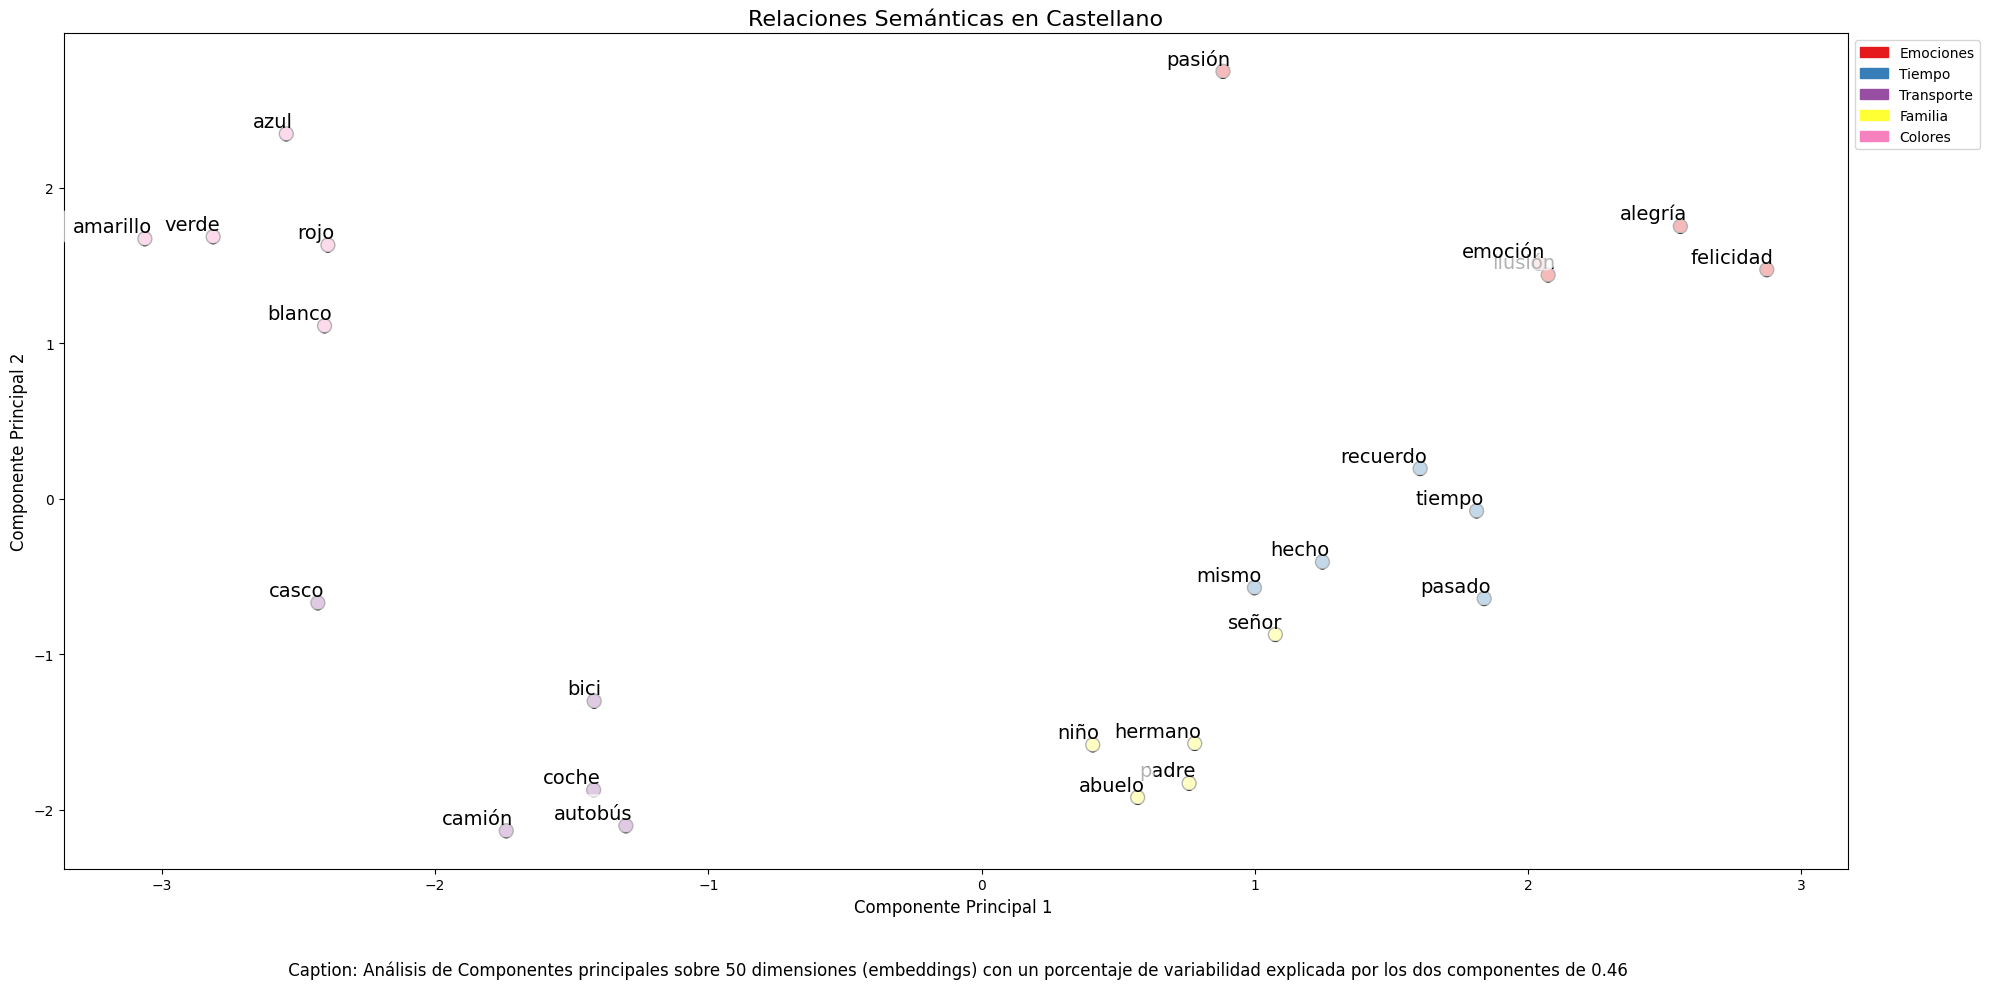

In [5]:
def test_embedding_castellano():
    """
    Realiza una evaluación de modelos de embedding sobre el idioma castellano

    Args:
    No tiene

    Descripción:
    Esta función realiza las siguientes acciones
    1. Muestra las tres palabras más próximas a las dadas en palabras_test y su nivel de similitud (similitud coseno).
    2. Evalúa la capacidad de reproducir las analogías dadas.
    3. Muestra los resultados esperados y obtenidos de la realización de operaciones vectoriales.
    4. Ejecuta a través de la función "visualizar_relaciones_semanticas" una reducción de dimensionalidad (50 a 2 dimensiones) y una representación gráfica
    de un término de cada categoría pre-seleccionada, representando los 4 términos más próximos en el espacio vectorial para poder evaluar la adecuación de los
    embeddings

    """

    # Se obtienen las tres palabras más similares a las palabras de la lista "palabras_test"
    print("\n1. Análisis de Similitud de Palabras")
    palabras_test = ['amor', 'trabajo', 'ciudad', 'tecnología', 'familia']
    resultados_similitud = []
    for palabra in palabras_test:
        try:
            similares = w2v.most_similar(palabra, topn=3)
            resultados_similitud.append([palabra] + [f"{sim[0]} ({sim[1]:.2f})" for sim in similares])
        except KeyError:
            resultados_similitud.append([palabra, "No se encuentra en el vocabulario", "", ""])

    print(tabulate(resultados_similitud, headers=["Palabra", "Palabra Similar 1", "Palabra Similar 2", "Palabra Similar 3"], tablefmt="grid"))

    # Se obtienen las analogías asociadas a las tres primeras palabras de cada elemento en analogías"
    print("\n2. Evaluación de Analogías")
    analogias = [
        ('hombre', 'mujer', 'rey', 'reina'),
        ('madrid', 'españa', 'parís', 'francia'),
        ('coche', 'carretera', 'tren', 'vía'),
    ]
    resultados_analogias = []
    for a, b, x, expected_y in analogias:
        try:
            resultado = w2v.most_similar(positive=[x, b], negative=[a], topn=1)[0]
            resultados_analogias.append([f"{a}:{b} :: {x}:{expected_y}", resultado[0], f"{resultado[1]:.2f}"])
        except KeyError:
            resultados_analogias.append([f"{a}:{b} :: {x}:{expected_y}", "Error", "N/A"])

    print(tabulate(resultados_analogias, headers=["Analogía y resultado esperado", "Resultado", "Similitud"], tablefmt="grid"))

    # Se aplican operaciones aritméticas sobre los distintos elementos de "operaciones"
    print("\n3. Operaciones Vectoriales")
    operaciones = [
        ('rey', 'hombre', 'mujer', 'reina'),
        ('madrid', 'españa', 'francia', 'parís')
    ]
    resultados_operaciones = []
    for a, b, c, expected in operaciones:
        try:
            vector = w2v[c] - w2v[a] + w2v[b]
            resultado = w2v.most_similar([vector], topn=1)[0]
            resultados_operaciones.append([f"{c} - {a} + {b}", expected, resultado[0], f"{resultado[1]:.2f}"])
        except KeyError:
            resultados_operaciones.append([f"{c} - {a} + {b}", expected, "Error", "N/A"])

    print(tabulate(resultados_operaciones, headers=["Operación", "Esperado", "Resultado", "Similitud"], tablefmt="grid"))


    visualizar_relaciones_semanticas(w2v)

#Se visualizan las relaciones semánticas
def visualizar_relaciones_semanticas(model):
    categorias = {
        'Emociones': ['alegría', 'felicidad', 'tristeza', 'pena', 'amor', 'odio', 'miedo', 'valentía'],
        'Tiempo': ['pasado', 'presente', 'futuro', 'ayer', 'hoy', 'mañana', 'semana', 'mes', 'año'],
        'Transporte': ['coche', 'automóvil', 'avión', 'vuelo', 'barco', 'navegar', 'tren', 'vía', 'bicicleta'],
        'Familia': ['padre', 'madre', 'hijo', 'hija', 'hermano', 'hermana', 'abuelo', 'abuela'],
        'Colores': ['rojo', 'azul', 'verde', 'amarillo', 'blanco', 'negro']
    }

    palabras = []
    vectores = []
    colores = []
    color_map = plt.colormaps.get_cmap('Set1')  # Cambiado para evitar el warning
    for i, (categoria, palabras_cat) in enumerate(categorias.items()):
        color = color_map(i / len(categorias))
        for palabra in palabras_cat[:1]:
            if palabra in model.key_to_index:
                palabras.append(palabra)
                vectores.append(model[palabra])
                colores.append(color)
                similares = model.most_similar(palabra, topn=4)
                for similar, _ in similares:
                    if similar not in palabras:
                        palabras.append(similar)
                        vectores.append(model[similar])
                        colores.append(color)

    vectores = np.array(vectores)
    pca = PCA(n_components=2)  # Reducir a 2 dimensiones
    vectores_2d = pca.fit_transform(vectores)

    varianza_explicada = pca.explained_variance_ratio_.sum()  # Variabilidad explicada

    fig, ax = plt.subplots(figsize=(20, 10))

    scatter = ax.scatter(vectores_2d[:, 0], vectores_2d[:, 1], c=colores,
                         alpha=1, s=100, edgecolors='black')

    for i, palabra in enumerate(palabras):
        ax.annotate(palabra, (vectores_2d[i, 0], vectores_2d[i, 1]),
                    xytext=(5, 2), textcoords='offset points',
                    ha='right', va='bottom', fontsize=14,
                    bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='none', alpha=0.7))

    plt.title("Relaciones Semánticas en Castellano", fontsize=16)
    plt.xlabel(f"Componente Principal 1 \n\n\n Caption: Análisis de Componentes principales sobre 50 dimensiones (embeddings) con un porcentaje de variabilidad explicada por los dos componentes de {varianza_explicada:.2f}", fontsize=12)
    plt.ylabel("Componente Principal 2", fontsize=12)

    # Leyenda para las categorías
    handles = [plt.Rectangle((0,0),1,1, color=color_map(i / len(categorias))) for i in range(len(categorias))]
    plt.legend(handles, categorias.keys(), loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()




test_embedding_castellano()

A continuación, se presentan las conclusiones generales de cada una de las evaluaciones realizadas:

**1. Similitud de Palabras**:
el modelo muestra una comprensión sólida de las relaciones semánticas entre palabras en castellano. En la mayoría de los casos, identifica correctamente términos relevantes y contextualmente apropiados. Por ejemplo, al asociar "trabajo" con "trabajar" y "proyecto", el modelo refleja un buen manejo de conceptos relacionados.

**2. Evaluación de Analogías**:
el modelo tiene un rendimiento variable en las analogías. Logra captar correctamente algunas relaciones semánticas, como en el caso de "hombre:mujer :: rey:reina". Sin embargo, falla en otras, como la analogía geográfica "madrid:españa :: parís:francia", donde ofrece una respuesta incorrecta ("noruega") pero muy aproximada.

**3. Operaciones Vectoriales**:
el modelo responde de manera satisfactoria en las operaciones vectoriales, mostrando un buen entendimiento de las relaciones entre conceptos. Por ejemplo, al resolver la operación "mujer - rey + hombre", el resultado "mujer" indica una correcta manipulación vectorial. Sin embargo, aunque la similitud es alta, no siempre se obtiene el resultado esperado, lo que sugiere que la precisión podría ser mejor.

En resumen, el modelo de *embeddings* presenta una capacidad suficiente para captar la semántica en castellano, con buenos resultados en contextos generales.


## 2. Obtención y limpieza de los datos

Para la obtención de los datos, se utiliza la [API pública](https://datos.gob.es/es/apidata) del portal que permite acceder a los mismos. Si deseas conocer cómo utilizar la API de datos.gob.es, te lo explicamos en [este vídeo](https://www.youtube.com/watch?v=UzOK0TdnCM0).

El proceso de recolección se basa en la realización de solicitudes paginadas a esta API, empleando parámetros de consulta para controlar tanto el número de resultados por página como la página específica a recuperar. De esta manera, se garantiza una extracción eficiente y controlada de los datos.

Durante la iteración sobre las páginas de resultados, se aplica un filtro para seleccionar únicamente aquellos conjuntos de datos cuyo contenido esté en castellano (de base tiene el castellano, además de otros idiomas). A partir de estos conjuntos de datos seleccionados, se extraen y almacenan tres elementos clave: el título, las palabras clave asociadas y la descripción. Este proceso se repite hasta alcanzar un límite predefinido de conjuntos de datos o hasta que se hayan agotado todos los resultados disponibles. En este caso, para agilizar el proceso y mantener un número suficientemente alto de *datasets* que hagan del motor de recomendación un motor preciso, se procesarán 20.000 *datasets* de los más de 90.000 que contiene el catálogo.

Finalmente, toda la información recopilada se organiza y estructura en un dataframe de pandas. Este dataframe, que contiene los títulos, palabras clave y descripciones de los conjuntos de datos, se convierte en la base fundamental para la construcción del "motor de recomendación". Este motor aprovechará la similitud semántica entre los títulos y descripciones de los conjuntos de datos para ofrecer etiquetas precisas y relevantes a los usuarios.

In [7]:
import requests

def get_datasets(limit=20000):
    # URL de la API y parámetros de consulta iniciales
    url, params = "https://datos.gob.es/apidata/catalog/dataset", {"_sort": "title", "_pageSize": 100, "_page": 0}
    all_data = []
    while len(all_data) < limit:
        # Realizar solicitud GET a la API
        response = requests.get(url, params=params)
        if response.status_code != 200: break  # Salir si la solicitud falla

        # Añadir pausa de 1 segundo entre peticiones
        time.sleep(1)

        # Extraer items de la respuesta JSON
        items = response.json()['result']['items']
        if not items: break  # Salir si no hay más items

        for item in items:
            if len(all_data) >= limit: break  # Salir si se alcanza el límite

            # Extraer título, keywords y descripción en castellano
            title_es = next((t['_value'] for t in item.get('title', []) if t.get('_lang') == 'es'), None)
            keywords_es = [k['_value'] for k in item.get('keyword', []) if k.get('_lang') == 'es']
            description_es = next((d['_value'] for d in item.get('description', []) if d.get('_lang') == 'es'), None)

            # Añadir a all_data si hay contenido en castellano
            if title_es and description_es:
                all_data.append({'Título': title_es, 'Keywords': ', '.join(keywords_es), 'Descripción': description_es})

        params['_page'] += 1  # Avanzar a la siguiente página

        if len(all_data) <= 1000:
            print(f"Procesados {len(all_data)} datasets...")
        elif len(all_data) % 500 == 0:
            print(f"Procesados {len(all_data)} datasets...")

        if len(all_data) >= limit: break  # Salir si se alcanza el límite

    return pd.DataFrame(all_data[:limit])  # Convertir a dataframe y limitar al número especificado

# Ejecutar la función y guardar resultados
df = get_datasets()

Procesados 100 datasets...
Procesados 200 datasets...
Procesados 300 datasets...
Procesados 400 datasets...
Procesados 500 datasets...
Procesados 600 datasets...
Procesados 700 datasets...
Procesados 800 datasets...
Procesados 900 datasets...
Procesados 1000 datasets...
Procesados 1500 datasets...
Procesados 2000 datasets...
Procesados 2500 datasets...
Procesados 3000 datasets...
Procesados 3500 datasets...
Procesados 4000 datasets...
Procesados 4500 datasets...
Procesados 5000 datasets...
Procesados 5500 datasets...
Procesados 6000 datasets...
Procesados 6500 datasets...
Procesados 7000 datasets...
Procesados 7500 datasets...
Procesados 8000 datasets...
Procesados 8500 datasets...
Procesados 9000 datasets...
Procesados 9500 datasets...
Procesados 10000 datasets...
Procesados 10500 datasets...
Procesados 11000 datasets...
Procesados 11500 datasets...
Procesados 12000 datasets...
Procesados 12500 datasets...
Procesados 13000 datasets...
Procesados 13500 datasets...
Procesados 14000 data

In [8]:
# Mostrar información del dataset
print("\nInformación del dataframe:")
print(tabulate([
    ["Número de filas", df.shape[0]],
    ["Número de columnas", df.shape[1]],
    ["Columnas", ", ".join(df.columns)],
    ["Tipos de datos", "\n".join([f"{col}: {dtype}" for col, dtype in df.dtypes.items()])],
    ["Memoria utilizada", f"{df.memory_usage(deep=True).sum() / 1024:.2f} KB"]
], headers=["Atributo", "Valor"], tablefmt="fancy_grid"))
# Imprimir una muestra de los datos
print("\nMuestra de los datos:")
df.head(5)


Información del dataframe:
╒════════════════════╤═══════════════════════════════╕
│ Atributo           │ Valor                         │
╞════════════════════╪═══════════════════════════════╡
│ Número de filas    │ 20000                         │
├────────────────────┼───────────────────────────────┤
│ Número de columnas │ 3                             │
├────────────────────┼───────────────────────────────┤
│ Columnas           │ Título, Keywords, Descripción │
├────────────────────┼───────────────────────────────┤
│ Tipos de datos     │ Título: object                │
│                    │ Keywords: object              │
│                    │ Descripción: object           │
├────────────────────┼───────────────────────────────┤
│ Memoria utilizada  │ 25699.43 KB                   │
╘════════════════════╧═══════════════════════════════╛

Muestra de los datos:


,Título,Keywords,Descripción
0,Agenda de Actividades Ciudad de Tarragona,"Agenda, actividades, cultura",Agenda de Actividades Ciudad de Tarragona
1,#català947. La lengua catalana en los municipi...,"català947, coneixementsiusoslingüístics, lleng...",#català947 és un projecte de la Secretaria de ...
2,Area Prevención Riesgos Erosión,"erosion, erosió, erosión, illes balears, risk ...",Area Prevención Riesgos Erosión
3,Áreas Prevención Riesgos Desprendimientos,"desprendimientos, esllevissaments, illes balea...",Áreas Prevención Riesgos Desprendimientos
4,Area Prevención Riesgos Inundaciones,"flood, illes balears, inundació, inundación, r...",Area Prevención Riesgos Inundaciones


### 2.1 Limpieza y Preprocesamiento de los Datos

En este punto, se llevarán a cabo una serie de transformaciones sobre el dataframe obtenido para prepararlo adecuadamente para su posterior análisis. El objetivo principal es asegurar la calidad de los datos y extraer características relevantes que faciliten el proceso de búsqueda y recomendación de etiquetas.


La función `procesar_dataframe` centraliza todas las operaciones de limpieza y transformación de los datos. Recibe como entrada el dataframe `df` y el modelo Word2Vec `w2v`. Utiliza las siguientes funciones auxiliares:

* `contiene_fecha_o_ano(keyword)`: utiliza expresiones regulares para identificar si una keyword contiene fechas o años, lo cual se utilizará para filtrar información no deseada.
* `limpiar_keywords(row)`: elimina las keywords que contienen fechas o años, dejando solo términos relevantes para la búsqueda.
* `limpiar_texto(texto)`: realiza una limpieza básica del texto, eliminando caracteres especiales y normalizando espacios en blanco.
* `combinar_titulo_descripcion(row)`: combina el título y la descripción de cada *dataset*, previamente limpiados, en un único campo de texto.
* `convertir_a_embedding(texto)`: utiliza el modelo Word2Vec para convertir el texto combinado en la función anterior en una representación vectorial (embedding) que captura su significado semántico.


In [9]:
def procesar_dataframe(df, w2v):
    """
    Procesa el dataframe limpiando keywords, combinando texto y generando embeddings.
    """

    def contiene_fecha_o_ano(keyword):
        """Verifica si una keyword contiene fechas o años."""
        if pd.isna(keyword):
            return False
        patrones = [
            r'\b\d{4}\b', # Años de 4 dígitos
            r'\b\d{1,2}/\d{1,2}/\d{2,4}\b', # Fechas en formato dd/mm/yyyy o similares
            r'\b\d{1,3}\s*(?:año|años|any|anys)\b', # Números seguidos de "año(s)" o "any(s)"
            r'\b(?:año|any)\s*\d{4}\b', # "Año" o "Any" seguido de 4 dígitos
            r'\bde\s+\d+\s+a\s+\d+\s+(?:año|años|any|anys)\b', # Rangos de edad
        ]
        return any(re.search(patron, str(keyword), re.IGNORECASE) for patron in patrones)

    def limpiar_keywords(row):
        """Limpia las keywords eliminando fechas y años."""
        if pd.isna(row):
            return ''
        return ','.join(kw.strip() for kw in str(row).split(',') if not contiene_fecha_o_ano(kw.strip()))

    def limpiar_texto(texto):
        """Limpia el texto eliminando caracteres especiales y normalizando espacios."""
        if pd.isna(texto):
            return ''
        texto_limpio = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]', '', str(texto))
        return ' '.join(texto_limpio.split()).lower()

    def combinar_titulo_descripcion(row):
        """Combina el título y la descripción limpios."""
        titulo = limpiar_texto(row['Título'])
        descripcion = limpiar_texto(row['Descripción'])
        texto_combinado = f"{titulo} {descripcion}".strip()
        return texto_combinado if texto_combinado else None

    def convertir_a_embedding(texto):
        """Convierte texto a embedding utilizando el modelo Word2Vec."""
        if pd.isna(texto) or texto == '':
            return np.zeros(w2v.vector_size)
        embeddings = [w2v[palabra] for palabra in texto.split() if palabra in w2v]
        return np.mean(embeddings, axis=0) if embeddings else np.zeros(w2v.vector_size)

    # Procesar el dataframe
    df['Keywords'] = df['Keywords'].apply(limpiar_keywords)
    df['texto_combinado'] = df.apply(combinar_titulo_descripcion, axis=1)
    df = df.dropna(subset=['texto_combinado'])
    df['embedding'] = df['texto_combinado'].apply(convertir_a_embedding)
    df = df[df['Keywords'] != '']

    return df

df_procesado = procesar_dataframe(df, w2v)
df_procesado.loc[116:117]

,Título,Keywords,Descripción,texto_combinado,embedding
116,Calles con plataforma única sin vehículos moto...,"Calles peatonales,Calles plataforma única",Calles con plataforma única sin vehículos moto...,calles con plataforma única sin vehículos moto...,"[-0.21734107, 0.44284078, 0.0035178363, -0.229..."
117,Cartografía SITXELL,"cartografia,informacion geografica,mapas",El proyecto SITXELL (Sistema d' Informació Ter...,cartografía sitxell el proyecto sitxell sistem...,"[0.08880808, 0.5662031, -0.20588946, 0.2841363..."


Podemos ver un ejemplo mostrado en consola con:

* **Nuevas Columnas:**
    * `texto_combinado`: Contiene el título y la descripción concatenados y limpios (en caso de ser distintos).
    * `embedding`: Contiene la representación del texto combinado en el espacio multidimensional, siendo la media de las representaciones de cada término en el texto combinado.

* **Keywords Limpias:** La columna que incluye las keywords se ha sobreescrito con las keywords limpias, eliminando fechas y años sueltos.

## 3. Motor de recomendación de etiquetas

En esta sección se desarrolla el núcleo del sistema de recomendación: un motor capaz de sugerir conjuntos de datos similares y sus etiquetas asociadas. Este componente se basa en la representación vectorial (*embeddings*) de los conjuntos de datos obtenida previamente, utilizando el título y la descripción de cada *dataset*.

La función *obtener_recomendaciones* es el corazón del motor de recomendación. Esta función toma el dataframe procesado y genera recomendaciones para cada conjunto de datos basándose en su similitud semántica. La función toma tres parámetros:

* `df`: dataframe que contiene los conjuntos de datos procesados, incluyendo sus *embeddings*.
* `umbral_similitud`: valor mínimo de similitud coseno para considerar dos conjuntos como similares (por defecto 0.5).
* `top_n`: número máximo de recomendaciones a generar por conjunto de datos (por defecto 3).

La función sigue estos pasos secuenciales:

1. **Preparación de datos**: el primer paso consiste en la validación de los datos de entrada, asegurando que todas las entradas en la columna 'Keywords' contengan cadenas de texto válidas para su procesamiento posterior.

2. **Cálculo de similitudes**: se procede a calcular una matriz completa de similitud coseno entre los *embeddings* de todos los conjuntos de datos disponibles en el sistema.

3. **Procesamiento por cada conjunto de datos**: para cada conjunto de datos en el sistema, se realiza un análisis donde se identifican otros conjuntos similares, excluyendo el propio conjunto del análisis. Este proceso incluye un filtrado basado en un umbral mínimo de similitud y la selección de los N conjuntos más relevantes.

4. **Extracción de información**: en esta fase se recopila toda la información relevante de los conjuntos similares identificados, incluyendo sus títulos, las palabras clave asociadas, las descripciones completas y los valores numéricos que indican el grado de similitud encontrado.

5. **Creación de nuevas columnas en el dataframe**: se enriquece el dataframe original mediante la adición de cuatro nuevas columnas: una para los títulos concatenados de los conjuntos similares, otra para las palabras clave únicas en mayúsculas, una tercera para las descripciones separadas por el carácter '|', y una última para los valores numéricos de similitud redondeados.

Como resultado del proceso, se obtiene un dataframe enriquecido que mantiene los datos originales y además incorpora toda la información de similitud generada en las etapas anteriores, proporcionando una visión completa de las relaciones entre conjuntos de datos.

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def obtener_recomendaciones(df, umbral_similitud=0.5, top_n=3):
    """
    Genera el dataframe que contiene el top_n conjuntos más similares de cada conjunto, trayendo sus etiquetas
    y sus puntuaciones de similitud.

    """
    # Aseguramos que todos los valores en 'Keywords' sean cadenas de texto para su split
    df['Keywords'] = df['Keywords'].fillna('').astype(str)

    # Calculamos la matriz de similitud coseno para todos los embeddings
    matriz_similitud = cosine_similarity(np.vstack(df['embedding'].values))

    # Función para obtener los top_n más similares excluyendo el propio
    def get_top_n(idx):
        similitudes = matriz_similitud[idx]
        # Ordenamos por similitud y filtramos por umbral
        indices_ordenados = np.argsort(similitudes)[::-1][1:]  # Excluimos el primero (el propio)
        indices_filtrados = [i for i in indices_ordenados if similitudes[i] >= umbral_similitud][:top_n]

        return list(zip(
            df['Título'].iloc[indices_filtrados],
            df['Keywords'].iloc[indices_filtrados],
            df['Descripción'].iloc[indices_filtrados],
            similitudes[indices_filtrados]
        ))

    # Aplicamos la función a cada fila
    resultados = [get_top_n(i) for i in range(len(df))]

    # Creamos las nuevas columnas
    df['Títulos_Similares'] = [', '.join([t for t, *_ in r]) for r in resultados]
    df['Keywords_Similares'] = [', '.join(set([k.upper() for _, kw, *_ in r for k in kw.split(',')])) for r in resultados]
    df['Descripciones_Similares'] = [' | '.join([d for _, _, d, _ in r]) for r in resultados]
    df['Similitudes'] = [[round(s, 3) for _, _, _, s in r] for r in resultados]

    return df

# Uso de la función
df_limpio= df_procesado
df_resultado = obtener_recomendaciones(df_limpio, umbral_similitud=0.5, top_n=3)

Ahora puede observarse el resultado obtenido, por ejemplo, para la primera fila del dataframe:

In [11]:
print(tabulate(df_resultado[['Título', 'Títulos_Similares', 'Keywords_Similares']].iloc[[0]].to_dict('records'), headers="keys", tablefmt="fancy_grid", maxcolwidths=[None, 20, 30]))

╒═══════════════════════════════════════════╤═════════════════════╤════════════════════════════════╕
│ Título                                    │ Títulos_Similares   │ Keywords_Similares             │
╞═══════════════════════════════════════════╪═════════════════════╪════════════════════════════════╡
│ Agenda de Actividades Ciudad de Tarragona │ Agenda de           │ EXPOSICIONES, ACTIVITATS,      │
│                                           │ actividades de la   │ TEATRO, EVENTS, CULTURA,       │
│                                           │ ciudad de Terrassa, │ CALENDAR, CALENDARI, AGENDA    │
│                                           │ Agenda cultural de  │ CULTURAL, TURISMO, CALENDARIO, │
│                                           │ la ciudad de        │ ACTIVIDADES, AGENDA, OCIO,     │
│                                           │ Barcelona, Agenda   │ EVENTOS                        │
│                                           │ Turística de la     │                        

La primera fila del dataframe original contiene información sobre el *dataset* "Agenda de Actividades Ciudad de Tarragona". El motor de recomendación ha generado las siguientes sugerencias:

* **Títulos Similares:**

  - Agenda de actividades de la ciudad de Terrassa
  - Agenda cultural de la ciudad de Barcelona
  - Agenda Turística de la ciudad de Cartagena

* **Keywords Similares:**

  CALENDAR, ACTIVIDADES, ACTIVITATS, AGENDA CULTURAL, CALENDARI, CULTURA, CALENDARIO, AGENDA, EVENTS, OCIO, TEATRO, EVENTOS, TURISMO, EXPOSICIONES

Estos resultados indican que el sistema ha identificado otros conjuntos de datos relacionados con agendas y actividades culturales en diferentes ciudades. Las keywords asociadas refuerzan esta interpretación, destacando términos como "calendario", "eventos", "cultura" y "ocio". Se obtiene así un sistema de recomendación interno que propone términos aplicables a un dataset, comparándolo con otros datasets del portal.


## 4. Incorporación de un tesauro armonizado de términos

Un paso más allá que puede ayudar en la estandarización de etiquetas es usar un corpus armonizado de términos predefinido, como [**Eurovoc**](https://eur-lex.europa.eu/browse/eurovoc.html?locale=es).

Además de obtener una descripción del tesauro, se puede descargar el archivo en formato `.xlsx` que contiene el corpus en castellano  desde el siguiente enlace pinchando en "EuroVoc_Excel_export.zip":
[Eurovoc](https://op.europa.eu/en/web/eu-vocabularies/dataset/-/resource?uri=http://publications.europa.eu/resource/dataset/eurovoc). Además, se encuentra en csv en el [repositorio público del ejercicio](https://github.com/Admindatosgobes/Laboratorio-de-Datos/blob/main/Visualizaciones/Word%20embeddings%20-%20ejercicio%20pr%C3%A1ctico%20con%20etiquetas%20de%20datos.gob/eurovoc_export_es_unzip.csv).

En este punto, se estarían **añadiendo los pasos 4 y 5** en la lógica del proceso de recomendación de etiquetas que se ha definido hasta ahora:

1. **Fusión de Título y Descripción**: se combinan el título y la descripción de cada *dataset*, creando una representación unificada en un vector.

2. **Matriz de Similitud**:  se genera una matriz de similitud entre los vectores del punto 1 para identificar los 3 *datasets* más similares a cada *dataset*.

3. **Extracción de Keywords Similares**:  se toman las keywords de los 3 *datasets* identificados como similares como posibles keywords relevantes.

4. **Comparación con Keywords de Eurovoc**:  se comparan los vectores que representan las keywords obtenidas en el paso 3 con los vectores que representan las keywords en Eurovoc.

5. **Obtención de Keywords Eurovoc Recomendadas**:  finalmente, se seleccionan las keywords de Eurovoc que sean más similares según la comparación de vectores, permitiendo la asignación de keywords armonizadas del tesauro a cada *dataset*.

Es necesario recordar que este proceso se está aplicando como una prueba de concepto didáctica sobre un conjunto muestral de *datasets*. Los resultados obtenidos dependen en gran medida de la calidad de la documentación y los metadatos de los *datasets*.

### 4.1 Aplicación de Eurovoc al sistema de recomendación
En primer lugar, tras haber descargado el zip con los distintos .xlsx, se importa el archivo con el corpus en castellano (en este caso, importamos del [repositorio](https://github.com/Admindatosgobes/Laboratorio-de-Datos/tree/main/Visualizaciones/Word%20embeddings%20-%20ejercicio%20pr%C3%A1ctico%20con%20etiquetas%20de%20datos.gob) el archivo ya descargado, descomprimido y convertido a csv) y se procesa la columna `TERMS (PT-NPT)`, que contiene el menor nivel de granularidad de Eurovoc, es decir, el mayor número de etiquetas posibles, 17208.
Después, se generan los *embeddings* de esos 17208 términos, los cuales se usarán para comparar con los *embeddings* generados en las keywords recomendadas de cada *dataset* (punto 3).

In [12]:
#Se generan individualmente funciones de limpieza utilizadas en el paso 2 para aplicarlas al conjunto de eurovoc
def process_keywords(text):
    if isinstance(text, str):
        return ' '.join(text.lower().split(","))
    return ''

def limpiar_texto(texto):
        """Limpia el texto eliminando caracteres especiales y normalizando espacios."""
        if pd.isna(texto):
            return ''
        texto_limpio = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]', '', str(texto))
        return ' '.join(texto_limpio.split()).lower()

def combinar_titulo_descripcion(row):
        """Combina el título y la descripción limpios."""
        titulo = limpiar_texto(row['Título'])
        descripcion = limpiar_texto(row['Descripción'])
        texto_combinado = f"{titulo} {descripcion}".strip()
        return texto_combinado if texto_combinado else None

def convertir_a_embedding(texto):
        """Convierte texto a embedding utilizando el modelo Word2Vec."""
        if pd.isna(texto) or texto == '':
            return np.zeros(w2v.vector_size)
        embeddings = [w2v[palabra] for palabra in texto.split() if palabra in w2v]
        return np.mean(embeddings, axis=0) if embeddings else np.zeros(w2v.vector_size)

In [13]:
# Leemos el tesauro del repositorio
try:
   url = "https://github.com/Admindatosgobes/Laboratorio-de-Datos/raw/main/Visualizaciones/Word%20embeddings%20-%20ejercicio%20pr%C3%A1ctico%20con%20etiquetas%20de%20datos.gob/eurovoc_export_es_unzip.csv"
   df = pd.read_csv(url, sep = ';')
except Exception as e:
   print(f"Error al descargar el archivo: {str(e)}")

# Limpiar la columna y generar nuevo dataframe
df['MT_cleaned'] = df['TERMS (PT-NPT)'].apply(lambda x: re.sub(r'^\d{4}\s*', '', str(x).strip()) if pd.notna(x) else x)
eurovoc = pd.DataFrame({"etiquetas": df['MT_cleaned'].unique().astype("str")})
df_resultado['keywords_embeddings'] = df_resultado['Keywords_Similares'].apply(process_keywords)

# Generamos los embeddings de las keywords de los datasets recomendados en el paso 3 y los de las keywords de eurovoc
df_resultado['embedding_keywords'] = df_resultado['keywords_embeddings'].apply(convertir_a_embedding)
eurovoc['embedding'] = eurovoc['etiquetas'].apply(convertir_a_embedding)

Con los *embeddings* de las keywords generados, se crea la función `asociacion_eurovoc`, que toma el dataframe con los *embeddings* de las keywords recomendadas en el punto 3 y el dataframe de Eurovoc y genera, imitando el proceso seguido en `obtener_recomendaciones`, las top_n etiquetas de Eurovoc más similares a las keywords recomendadas de cada *dataset*.

In [14]:
from tabulate import tabulate
def asociacion_eurovoc(df_resultado, eurovoc, top_n=3):
    # Convertir los embeddings a matrices numpy
    titulo_embeddings = np.array(df_resultado['embedding_keywords'].tolist())
    etiqueta_embeddings = np.array(eurovoc['embedding'].tolist())

    # Calcular similitud coseno entre todos los títulos y etiquetas
    similarities = cosine_similarity(titulo_embeddings, etiqueta_embeddings)

    # Encontrar las top_n etiquetas más similares para cada título
    top_indices = np.argsort(similarities, axis=1)[:, -top_n:][:, ::-1]

    # Crear nuevas columnas para las etiquetas y similitudes
    for i in range(top_n):
        df_resultado[f'etiqueta_{i+1}'] = eurovoc.loc[top_indices[:, i], 'etiquetas'].values
        df_resultado[f'similitud_{i+1}'] = similarities[np.arange(len(df_resultado)), top_indices[:, i]]

    return df_procesado

df_final = asociacion_eurovoc(df_resultado, eurovoc)
df_final['keywords_eurovoc_similares'] = df_final['etiqueta_1'] + ', ' + df_final['etiqueta_2'] + ', ' + df_final['etiqueta_3']
df_seleccion = df_final[['Título', 'Títulos_Similares', 'Keywords_Similares', 'keywords_eurovoc_similares']]
df_final[['Título', 'Títulos_Similares', 'Keywords_Similares', 'keywords_eurovoc_similares']].head(2)

,Título,Títulos_Similares,Keywords_Similares,keywords_eurovoc_similares
0,Agenda de Actividades Ciudad de Tarragona,Agenda de actividades de la ciudad de Terrassa...,"EXPOSICIONES, ACTIVITATS, TEATRO, EVENTS, CULT...","turismo cultural, promoción cultural, industri..."
1,#català947. La lengua catalana en los municipi...,Encuesta barómetro del impacto de la COVID19 s...,"COVID, ODS16_PAU JUSTÍCIES I INSTITUCIONS SÒLI...","Grupo ad hoc de inmigración, estimación de la ..."


Con el uso de graphviz puede representarse gráficamente el flujo completo del motor de recomendación para un dataset dado. De este modo el diagrama de flujo muestra para el caso de ejemplo (Agenda de Actividades Ciudad de Tarragona) las tres partes del proceso:

**1. Conjuntos de datos similares** : los datasets más similares al dataset Agenda de Actividades Ciudad de Tarragona en función de su título y descripción.

**2. Etiquetas asociadas** : las etiquetas asociadas a los *datasets* más similares recogidos en el punto 1.

**2. Etiquetas Eurovoc** : las etiquetas Eurovoc más similares a las etiquetas obtenidas en el punto 2.

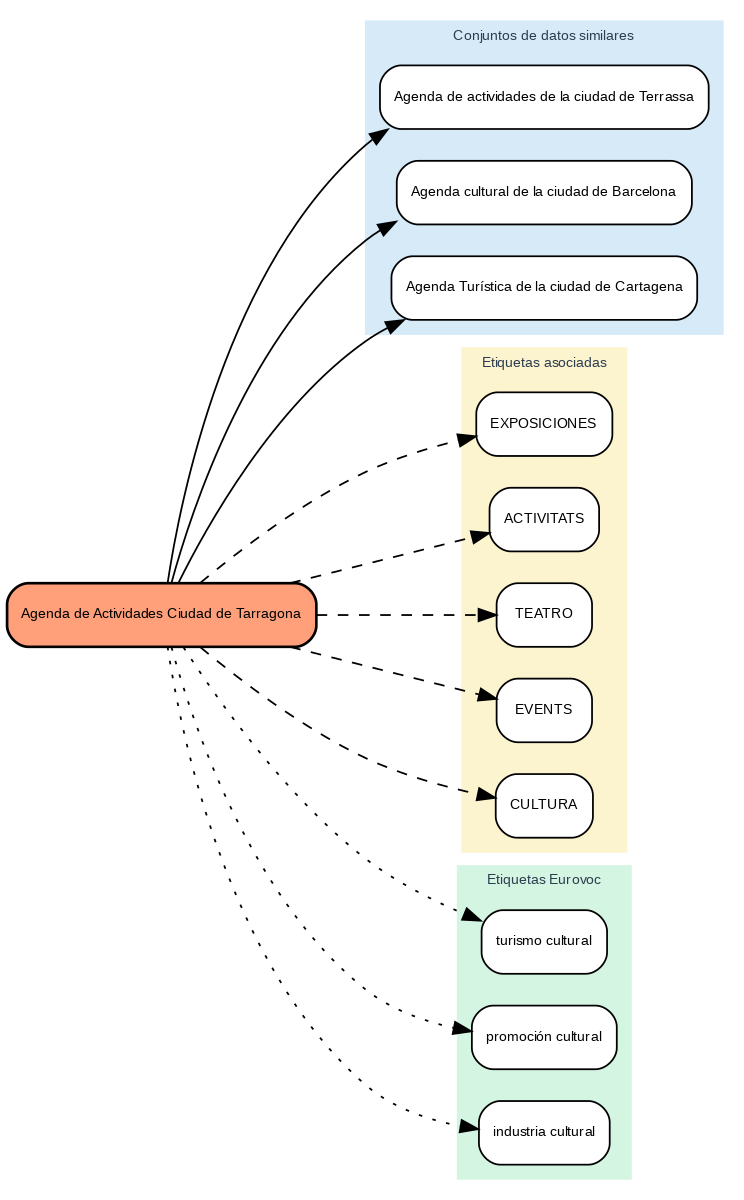

In [16]:
from graphviz import Digraph
from IPython.display import display, Image

def crear_diagrama_flujo(row):
    titulo = row['Título']
    titulos_similares = row['Títulos_Similares'].split(', ')
    keywords_similares = row['Keywords_Similares'].split(', ')
    keywords_eurovoc_similares = row['keywords_eurovoc_similares'].split(', ')

    # Limpiar espacios en blanco extras
    titulos_similares = [t.strip() for t in titulos_similares]
    keywords_similares = [k.strip() for k in keywords_similares]
    keywords_eurovoc_similares = [k.strip() for k in keywords_eurovoc_similares]

    # Crear un nuevo grafo
    dot = Digraph(comment='Diagrama de Flujo de Similitudes')
    dot.attr(rankdir='LR', size='8,6', dpi='200', fontname='Helvetica', fontsize='8')

    # Estilos generales
    dot.attr('node', shape='rectangle', style='rounded,filled', fontname='Helvetica', fontsize='8')
    dot.attr('edge', fontname='Helvetica', fontsize='6', len='1.2')

    # Añadir el nodo principal (Título)
    dot.node('titulo', titulo, fillcolor='#FFA07A', style='filled,rounded', penwidth='1.5', fontcolor='black')

    # Crear un subgrafo para los títulos similares
    with dot.subgraph(name='cluster_titulos_similares') as c:
        c.attr(label='Conjuntos de datos similares', style='filled', color='#D6EAF8', fontcolor='#2C3E50', fontsize='8')
        for i, titulo in enumerate(titulos_similares[:3]):  # Limitamos a 3 títulos similares
            nodo_id = f'titulo_similar_{i}'
            c.node(nodo_id, titulo, fillcolor='white')
            dot.edge('titulo', nodo_id)

    # Crear un subgrafo para las keywords similares
    with dot.subgraph(name='cluster_keywords_similares') as c:
        c.attr(label='Etiquetas asociadas', style='filled', color='#FCF3CF', fontcolor='#2C3E50', fontsize='8')
        c.attr('node', shape='ellipse')
        for i, keyword in enumerate(keywords_similares[:5]):  # Limitamos a 5 keywords
            keyword_id = f'keyword_{i}'
            c.node(keyword_id, keyword, fillcolor='white')
            dot.edge('titulo', keyword_id, style='dashed')

    # Procesar Keywords Eurovoc Similares
    with dot.subgraph(name='cluster_keywords_eurovoc') as c:
        c.attr(label='Etiquetas Eurovoc', style='filled', color='#D5F5E3', fontcolor='#2C3E50', fontsize='8')
        c.attr('node', shape='diamond')
        for i, keyword in enumerate(keywords_eurovoc_similares[:5]):  # Limitamos a 5 keywords Eurovoc
            eurovoc_id = f'eurovoc_{i}'
            c.node(eurovoc_id, keyword, fillcolor='white')
            dot.edge('titulo', eurovoc_id, style='dotted')

    # Renderizar el grafo y mostrarlo
    img = dot.pipe(format='png')
    display(Image(img))

row = df_final.iloc[0]  # Selecciona la primera fila
crear_diagrama_flujo(row)

Puede observarse cómo la primera fila del *dataset* (Agenda de Actividades Ciudad de Tarragona) incluye las keywords armonizadas del tesauro europeo:

- Turismo cultural
- Promoción cultural
- Industria cultural

Keywords que casan perfectamente con, al menos, la naturaleza semántica del título del *dataset*.

El uso de los términos de Eurovoc, es de por sí una buena práctica para la gestión de etiquetas, pero además, como se ha demostrado, se puede utilizar para “mapear” un etiquetado dado a un etiquetado estandarizado basado en el vocabulario Eurovoc.